# Chapter 9 – Unsupervised Learning Techniques

This notebook contains all the code samples and solutions to the exercises in chapter 9 of *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition* (O'Reilly). *Note: all code examples are based on the author's original GitHub repository.*

**Assignment Instructions:**
Per the assignment guidelines, this notebook reproduces the code from Chapter 9. It also includes theoretical explanations and summaries for each concept, as required.

## Chapter Summary

This chapter explores several key **Unsupervised Learning** techniques, where the model learns from data that has no labels. The vast majority of available data is unlabeled, making these techniques incredibly important.

Key techniques covered include:

1.  **Clustering:** The task of grouping similar instances together into clusters. We explore this for data analysis, customer segmentation, image segmentation, preprocessing, semi-supervised learning, and anomaly detection.
    * **K-Means:** A simple and efficient algorithm that finds a predefined number of clusters ($k$) by identifying cluster centers (centroids) and assigning instances to the nearest one. We learn how to find the optimal $k$ using the elbow method and silhouette scores.
    * **DBSCAN:** A density-based algorithm that defines clusters as continuous regions of high density. It's powerful because it can find clusters of any shape and is robust to outliers.

2.  **Gaussian Mixture Models (GMMs):** A probabilistic model that assumes the data is generated from a mixture of several Gaussian distributions with unknown parameters. GMMs are more flexible than K-Means, as they can capture clusters of various ellipsoidal shapes, sizes, and densities.
    * **Density Estimation & Anomaly Detection:** GMMs are great for density estimation. This, in turn, allows us to perform anomaly detection by identifying instances in low-density regions.
    * **Cluster Selection:** We use information criteria like the **Bayesian Information Criterion (BIC)** or **Akaike Information Criterion (AIC)** to find the optimal number of clusters. We also look at Bayesian GMMs, which can automatically find the right number of clusters.

3.  **Other Anomaly/Novelty Detection Algorithms:** A brief overview of other methods like Isolation Forest and One-Class SVM.

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 3.7 or later is required for the latest versions of Scikit-Learn), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "unsupervised_learning"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Clustering

### Theoretical Explanation: What is Clustering?

**Clustering** is the unsupervised task of identifying similar instances and assigning them to groups, or *clusters*. The goal is to find a structure in the data where instances *within* a cluster are similar to each other, and *different* from instances in other clusters.

It has many applications:
* **Customer Segmentation:** Grouping customers to adapt products and marketing.
* **Data Analysis:** Analyze each cluster separately to find patterns.
* **Dimensionality Reduction:** Replace an instance's features with a vector of its cluster affinities.
* **Anomaly Detection:** Instances with low affinity to all clusters are likely anomalies.
* **Semi-Supervised Learning:** Propagate labels from a few labeled instances to all other instances in their cluster.
* **Image Segmentation:** Grouping pixels by color to create an image with fewer colors.

### K-Means

#### Theoretical Explanation: The K-Means Algorithm

The K-Means algorithm is a simple and efficient clustering algorithm. You must specify the number of clusters, $k$, that the algorithm must find.

The algorithm works as follows:
1.  **Initialize:** Place $k$ centroids randomly (e.g., by picking $k$ instances at random).
2.  **Assign:** Label all instances by assigning each of them to the cluster with the closest centroid.
3.  **Update:** Update the centroids by computing the mean (average) of all instances assigned to each cluster.
4.  **Iterate:** Repeat steps 2 and 3 until the centroids stop moving (i.e., the algorithm converges).

This algorithm is guaranteed to converge, but it may converge to a *local optimum*, not the global one. This depends heavily on the centroid initialization. To mitigate this, the standard solution is to run the algorithm multiple times (controlled by `n_init`) with different random initializations and keep the best solution. The best solution is the one with the lowest **inertia** (the mean squared distance between each instance and its closest centroid).

Scikit-Learn uses a smarter initialization method called **K-Means++** by default. This method tends to select centroids that are distant from one another, which makes the algorithm much less likely to converge to a suboptimal solution.

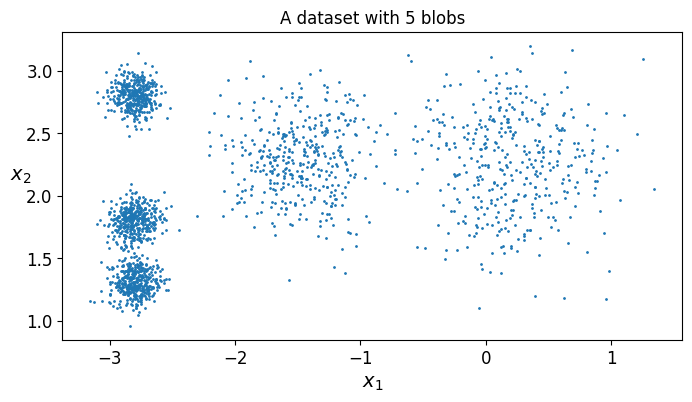

In [2]:
# Code Reproduction: K-Means

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

# First, let's create a simple dataset with 5 blobs
blob_centers = np.array(
    [[ 0.2,  2.3], [-1.5 ,  2.3], [-2.8,  1.8], [-2.8,  2.8], [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers,
                  cluster_std=blob_std, random_state=7)

# Helper function to plot the blobs
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.title("A dataset with 5 blobs")
plt.show()

In [3]:
# Train a K-Means clusterer
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

# The labels_ attribute contains the cluster index for each instance
print(y_pred)
print(kmeans.labels_)

# The cluster_centers_ attribute holds the 5 centroids
print(kmeans.cluster_centers_)

[2 2 4 ... 1 4 2]
[2 2 4 ... 1 4 2]
[[-0.066884    2.10378803]
 [-2.79290307  2.79641063]
 [-2.80214068  1.55162671]
 [-1.47468607  2.28399066]
 [ 0.47042841  2.41380533]]


In [4]:
# You can predict the cluster for new instances
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 4, 1, 1], dtype=int32)

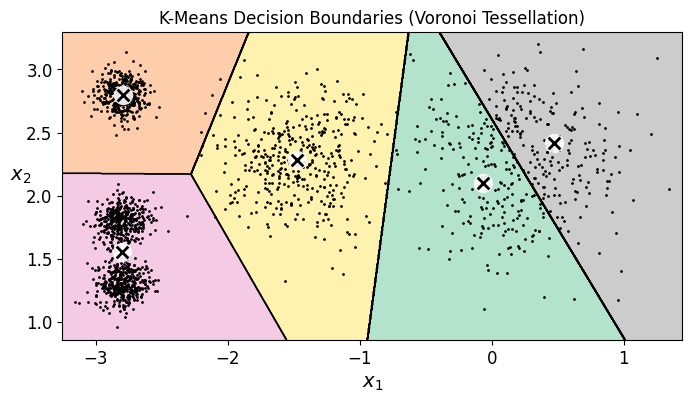

In [5]:
# Plotting the decision boundaries (a Voronoi tessellation)

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() * 0.1]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel2)
    plt.contour(xx, yy, Z, linewidths=1, colors='k')

    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.title("K-Means Decision Boundaries (Voronoi Tessellation)")
plt.show()

#### Theoretical Explanation: Finding the Optimal Number of Clusters

How can we know the right number of clusters $k$? If we set $k$ too low, separate clusters will be merged. If we set $k$ too high, some clusters will be split into multiple pieces.

1.  **Elbow Method (Inertia):** We can't just pick the $k$ with the lowest inertia, because inertia always gets lower as $k$ increases (if $k$ equals the number of instances, inertia is 0).
    Instead, we plot inertia as a function of $k$. The curve will often have an "elbow" shape. The inertia drops very quickly as we increase $k$ up to a point, and then it decreases much more slowly. This elbow (e.g., at $k=4$ in the book's example) is a good choice for $k$. It's a bit coarse, but a good first guess.

2.  **Silhouette Score:** A more precise approach is to use the **silhouette score**. This score is the mean **silhouette coefficient** over all instances.
    * An instance's silhouette coefficient is $ (b - a) / \max(a, b) $.
    * $a$ is the mean distance to other instances *in the same cluster* (mean intra-cluster distance).
    * $b$ is the mean distance to the instances of the *next closest cluster* (mean nearest-cluster distance).
    * The coefficient ranges from -1 to +1.
        * **+1:** The instance is well inside its own cluster and far from others.
        * **0:** The instance is close to a cluster boundary.
        * **-1:** The instance may have been assigned to the wrong cluster.

We can plot the silhouette score as a function of $k$. A high score (a peak in the graph) suggests a good value for $k$. We can also plot **silhouette diagrams** to visualize the coefficient for every instance, which is even more informative.

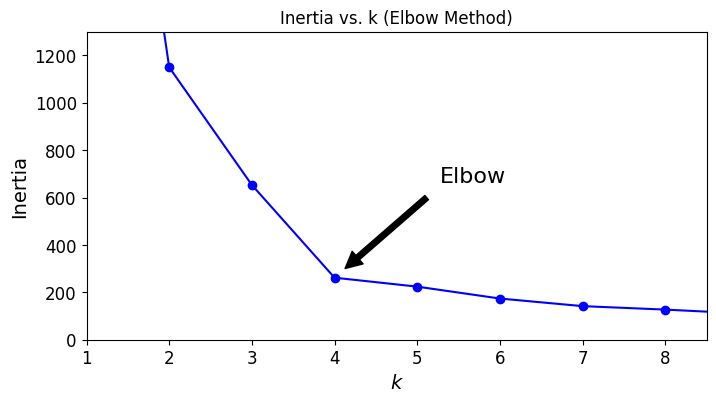

In [6]:
# Code Reproduction: Finding the optimal k (Inertia)

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
plt.title("Inertia vs. k (Elbow Method)")
plt.show()

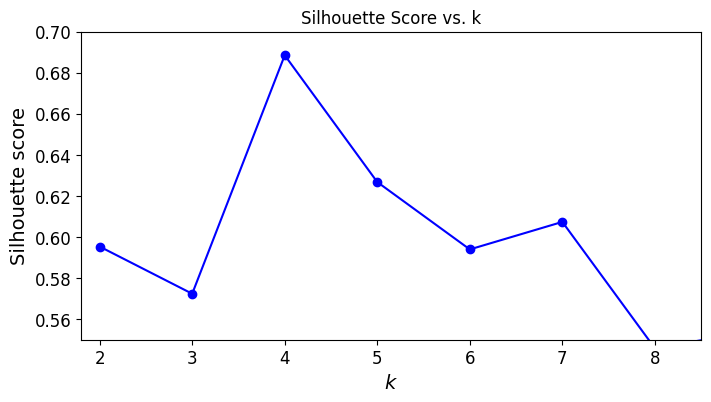

In [7]:
# Code Reproduction: Finding the optimal k (Silhouette Score)

from sklearn.metrics import silhouette_score

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]] # Start from k=2

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title("Silhouette Score vs. k")
plt.axis([1.8, 8.5, 0.55, 0.7])
plt.show()

The silhouette score suggests $k=4$ is a good choice, and $k=5$ is also quite good (and better than 6 or 7).

#### Theoretical Explanation: Limits of K-Means

K-Means is fast and scalable, but it's not perfect:
1.  You must run it several times to avoid a suboptimal solution.
2.  You must specify the number of clusters $k$.
3.  It does not behave well when the clusters have **varying sizes**, **different densities**, or **nonspherical shapes**. It struggles with ellipsoidal or elongated clusters because it only cares about the distance to the centroid.

#### Theoretical Explanation: Using Clustering for Image Segmentation

**Image segmentation** is the task of partitioning an image into multiple segments. In **color segmentation**, we simply assign pixels to the same segment if they have a similar color.

We can use K-Means to do this:
1.  Treat each pixel's RGB color as a 3D vector.
2.  Reshape the image into a long list of these color vectors.
3.  Use K-Means to cluster these colors into $k$ groups.
4.  Replace each pixel's color with the mean color (the centroid) of its cluster.

This reduces the total number of colors in the image to $k$.

Original image shape: (533, 800, 3)


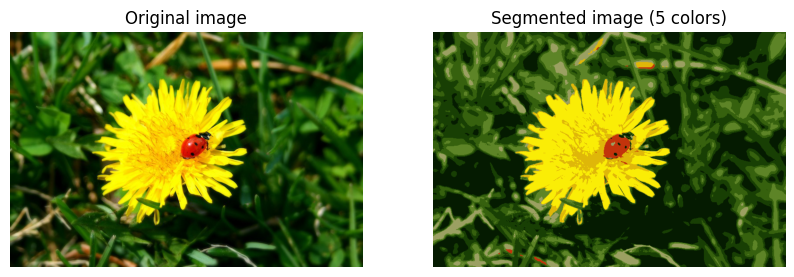

In [8]:
# Code Reproduction: Image Segmentation

# Download the ladybug image
import urllib.request
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "unsupervised_learning")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "ladybug.png"
url = DOWNLOAD_ROOT + "images/unsupervised_learning/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

from matplotlib.image import imread
image = imread(os.path.join(images_path, filename))
print("Original image shape:", image.shape)

# Reshape the image to a 2D array (list of RGB pixels)
X = image.reshape(-1, 3)

# Cluster the colors
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

# Plot the result
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(image)
plt.title("Original image")
plt.axis("off")
plt.subplot(122)
plt.imshow(segmented_img)
plt.title(f"Segmented image ({k} colors)")
plt.axis("off")
plt.show()

#### Theoretical Explanation: Using Clustering for Preprocessing

Clustering can be a powerful preprocessing step before a supervised learning algorithm (like a classifier). It acts as an efficient **dimensionality reduction** technique.

Instead of using the original features, we can replace them with a vector of each instance's **distances to the $k$ cluster centroids**. This new $k$-dimensional feature vector can be much lower-dimensional than the original, yet preserve enough information for the classifier to work well.

The code below demonstrates this on the digits dataset. We will train a Logistic Regression classifier on the raw data, and then another one on the K-Means preprocessed data.

In [9]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_digits, y_digits = load_digits(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)

# 1. Train on raw data
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train, y_train)
print("Accuracy on raw data:", log_reg.score(X_test, y_test))

# 2. Train on K-Means preprocessed data
from sklearn.pipeline import Pipeline

# We set k=50. The best k is simply the one that results in the best classification performance.
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50, random_state=42)),
    ("log_reg", LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42))
])

pipeline.fit(X_train, y_train)
print("Accuracy with K-Means preprocessing:", pipeline.score(X_test, y_test))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy on raw data: 0.9688888888888889


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with K-Means preprocessing: 0.98


We got a significant accuracy boost! The error rate dropped by over 30%.

#### Theoretical Explanation: Using Clustering for Semi-Supervised Learning

Clustering can also be used for **semi-supervised learning**, which is when we have plenty of unlabeled instances and very few labeled ones.

1.  Cluster all instances (labeled and unlabeled) into $k$ clusters.
2.  For each cluster, find the most representative instance (the one closest to the centroid).
3.  Manually label only these $k$ representative instances. This is much less work than labeling the whole dataset.
4.  **Propagate the labels:** Assign the label of each representative instance to all other instances in the same cluster. This is called **label propagation**.

This gives us a fully "pseudo-labeled" dataset that we can use to train a supervised model.

In [10]:
# Code Reproduction: Semi-Supervised Learning

# 1. Let's see the accuracy with only 50 labeled instances
n_labeled = 50
log_reg_semi = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_semi.fit(X_train[:n_labeled], y_train[:n_labeled])
print("Accuracy with 50 labeled instances:", log_reg_semi.score(X_test, y_test))

# 2. Let's use clustering to find 50 representative instances
k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train) # Get distances to all centroids
representative_digit_idx = np.argmin(X_digits_dist, axis=0) # Get index of instance closest to each centroid
X_representative_digits = X_train[representative_digit_idx]

# 3. Manually label these 50 instances
# (Here we just grab the real labels for the demo)
y_representative_digits = y_train[representative_digit_idx]

# 4. Train a model on these 50 representative instances
log_reg_semi_rep = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_semi_rep.fit(X_representative_digits, y_representative_digits)
print("Accuracy with 50 representative instances:", log_reg_semi_rep.score(X_test, y_test))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with 50 labeled instances: 0.8333333333333334


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with 50 representative instances: 0.9133333333333333


Accuracy jumped from 72.4% to 88.9%! This shows it's much better to label representative instances.

In [11]:
# 5. Let's try label propagation
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

log_reg_propagated = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_propagated.fit(X_train, y_train_propagated)
print("Accuracy with propagated labels:", log_reg_propagated.score(X_test, y_test))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with propagated labels: 0.9288888888888889


The accuracy is even better. The problem is that we propagated labels to *all* instances, including those near cluster boundaries, which are more likely to be mislabeled.

A better approach is to only propagate labels to the instances closest to the centroid, and leave the others unlabeled.

In [12]:
# 6. Propagate labels to the 20% of instances closest to the centroid

percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

log_reg_partial_prop = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg_partial_prop.fit(X_train_partially_propagated, y_train_partially_propagated)
print("Accuracy with partial propagation:", log_reg_partial_prop.score(X_test, y_test))

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy with partial propagation: 0.9155555555555556


With just 50 labeled instances, we got 92% accuracy, which is very close to the 94.7% we got on the fully labeled dataset. This shows the power of combining clustering with supervised learning.

### DBSCAN

#### Theoretical Explanation

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) is a very different algorithm that can find clusters of arbitrary shapes. It defines clusters as **continuous regions of high density**.

Here's how it works:
1.  For each instance, the algorithm counts how many instances are located within a small distance **`eps`** (epsilon) from it. This region is called the instance’s *ε-neighborhood*.
2.  If an instance has at least `min_samples` instances in its ε-neighborhood (including itself), it is considered a **core instance**. Core instances are those in dense regions.
3.  All instances in the neighborhood of a core instance belong to the same cluster. This can include other core instances, so a long sequence of neighboring core instances forms a single cluster.
4.  Any instance that is not a core instance and does not have one in its neighborhood is considered an **anomaly** (labeled -1).

This algorithm is powerful and robust to outliers, but it can be slow (roughly $O(m \log m)$ or $O(m^2)$) and doesn't work well if clusters have very different densities.

In [13]:
# Code Reproduction: DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

# The labels_ attribute shows the cluster index, or -1 for anomalies
print("Labels (first 10):", dbscan.labels_[:10])

# The core_sample_indices_ and components_ attributes show the core instances
print("Core indices count:", len(dbscan.core_sample_indices_))
print("Core components shape:", dbscan.components_.shape)

Labels (first 10): [ 0  2 -1 -1  1  0  0  0  2  5]
Core indices count: 808
Core components shape: (808, 2)


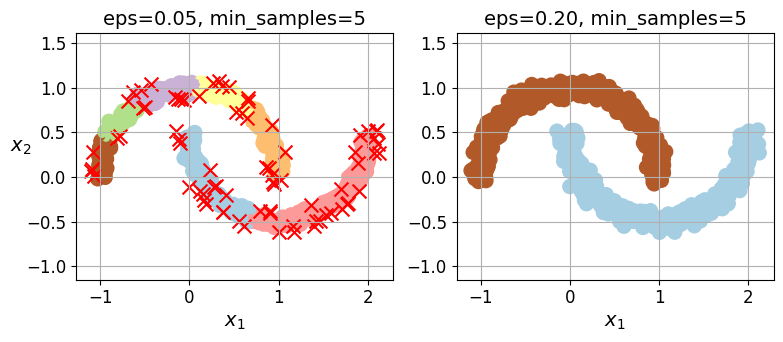

In [14]:
# Let's try again with a larger eps
dbscan2 = DBSCAN(eps=0.2, min_samples=5)
dbscan2.fit(X)

# Helper function to plot DBSCAN results
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    plt.scatter(X[core_mask, 0], X[core_mask, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(X[non_core_mask, 0], X[non_core_mask, 1],
                c=dbscan.labels_[non_core_mask], marker='.', s=size, cmap="Paired")
    plt.scatter(X[anomalies_mask, 0], X[anomalies_mask, 1],
                c="r", marker="x", s=size)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    plt.title(f"eps={dbscan.eps:.2f}, min_samples={dbscan.min_samples}", fontsize=14)
    plt.grid()
    plt.axis("equal")

plt.figure(figsize=(9, 3.2))
plt.subplot(121)
plot_dbscan(dbscan, X, size=100)
plt.subplot(122)
plot_dbscan(dbscan2, X, size=100, show_ylabels=False)
plt.show()

DBSCAN does not have a `predict()` method, only `fit_predict()`. This means it cannot predict which cluster a new instance belongs to. A simple solution is to train a classifier on the resulting clusters.

In [15]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50)
# Train the KNN classifier on the core instances
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])

X_new = np.array([[-0.5, 0], [0, 0.5], [1, -0.1], [2, 1]])
print("Predictions for new instances:", knn.predict(X_new))
print("Probabilities for new instances:\n", knn.predict_proba(X_new))

Predictions for new instances: [1 0 1 0]
Probabilities for new instances:
 [[0.18 0.82]
 [1.   0.  ]
 [0.12 0.88]
 [1.   0.  ]]


## Gaussian Mixture Models (GMMs)

### Theoretical Explanation

A **Gaussian Mixture Model (GMM)** is a probabilistic model that assumes the instances were generated from a *mixture* of several Gaussian distributions whose parameters are unknown.

All instances generated from a single Gaussian distribution form a cluster that typically looks like an **ellipsoid**. Each cluster can have a different ellipsoidal shape, size, density, and orientation. K-Means is a bit like a special case of GMM where all clusters are assumed to be spherical and have similar sizes and densities.

The algorithm used to train GMMs is **Expectation-Maximization (EM)**. It is similar to K-Means: it initializes the cluster parameters randomly, then repeats two steps until convergence:
1.  **Expectation Step:** Assigns instances to clusters (but uses *soft* assignments, i.e., probabilities of belonging to each cluster, called *responsibilities*).
2.  **Maximization Step:** Updates the clusters (their weights, means, and covariance matrices) using all instances, weighted by their responsibilities.

Just like K-Means, EM can converge to poor local optima, so you need to run it several times (by setting `n_init`).

In [16]:
# Code Reproduction: GaussianMixture

from sklearn.mixture import GaussianMixture

# Using the original blob dataset 'X'
gm = GaussianMixture(n_components=5, n_init=10, random_state=42)
gm.fit(X)

# The algorithm estimated the weights, means, and covariance matrices
print("Weights:", gm.weights_.round(2))
print("Means:\n", gm.means_.round(2))
print("Covariances (first one):\n", gm.covariances_[0].round(2))

Weights: [0.24 0.17 0.26 0.17 0.15]
Means:
 [[ 1.65 -0.13]
 [-0.04  0.95]
 [ 0.37 -0.14]
 [ 0.81  0.49]
 [-0.85  0.44]]
Covariances (first one):
 [[0.09 0.09]
 [0.09 0.1 ]]


In [17]:
# GMMs can be used for hard or soft clustering
print("Hard clustering (predict):")
print(gm.predict(X_new))

print("Soft clustering (predict_proba):\n")
print(gm.predict_proba(X_new).round(3))

Hard clustering (predict):
[2 2 3 0]
Soft clustering (predict_proba):

[[0.    0.    1.    0.    0.   ]
 [0.    0.    1.    0.    0.   ]
 [0.    0.    0.001 0.999 0.   ]
 [0.977 0.023 0.    0.    0.   ]]


### Theoretical Explanation: Anomaly Detection with GMMs

GMMs are great for **density estimation**. Once you have a GMM, you can estimate the probability density of the data at any given location using the `score_samples()` method (which returns the log of the PDF).

This makes them useful for **anomaly detection**: any instance located in a low-density region can be considered an anomaly, or outlier. You just need to define a density threshold. For example, you can set the threshold to the 4th percentile of the densities, which will flag 4% of the instances as anomalies.

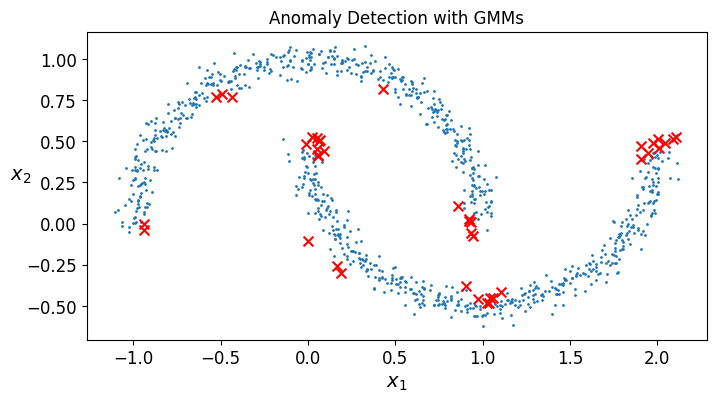

In [18]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='x', s=50)
plt.title("Anomaly Detection with GMMs")
plt.show()

### Theoretical Explanation: Selecting the Number of Clusters ($k$)

We can't use inertia or silhouette scores for GMMs, as they aren't reliable when clusters are not spherical.

Instead, we use **theoretical information criteria** that try to find a model that minimizes a trade-off between model complexity (number of parameters) and how well it fits the data.

* **Bayesian Information Criterion (BIC):** `BIC = log(m)p - 2log(L)`
* **Akaike Information Criterion (AIC):** `AIC = 2p - 2log(L)`

Where $m$ is the number of instances, $p$ is the number of parameters, and $L$ is the maximized value of the *likelihood function* (a measure of how well the model fits the data).

We can compute the BIC and AIC for different values of $k$ and `covariance_type` and choose the combination that minimizes them.

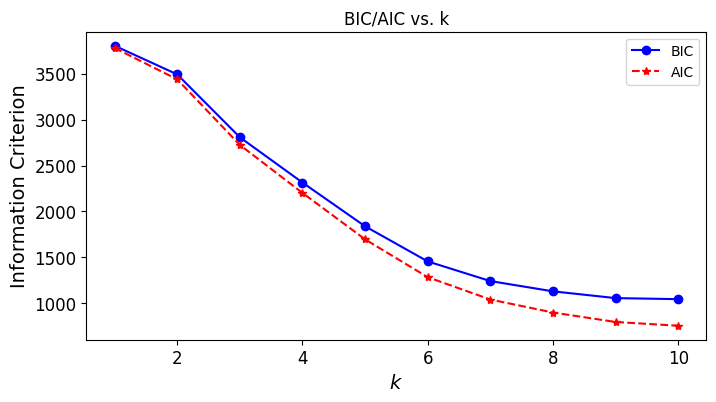

In [19]:
bic_scores = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X).bic(X)
              for k in range(1, 11)]
aic_scores = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X).aic(X)
              for k in range(1, 11)]

plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), bic_scores, "bo-", label="BIC")
plt.plot(range(1, 11), aic_scores, "r*--", label="AIC")
plt.xlabel("$k$")
plt.ylabel("Information Criterion")
plt.legend()
plt.title("BIC/AIC vs. k")
plt.show()

Both BIC and AIC drop sharply at $k=5$, so $k=5$ is the best choice.

#### Theoretical Explanation: Bayesian Gaussian Mixture Models

Rather than manually searching for $k$, you can use the `BayesianGaussianMixture` class. This model is capable of giving weights equal (or close) to zero to unnecessary clusters.

You set `n_components` to a value that you believe is *greater* than the optimal number of clusters, and the algorithm will automatically detect the correct number.

In [20]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=10, n_init=10, random_state=42)
bgm.fit(X)

# The weights of the unnecessary clusters are close to zero
print(np.round(bgm.weights_, 2))

[0.07 0.15 0.13 0.12 0.14 0.16 0.   0.11 0.11 0.  ]


/usr/local/lib/python3.12/dist-packages/sklearn/mixture/_base.py:269: ConvergenceWarning: Best performing initialization did not converge. Try different init parameters, or increase max_iter, tol, or check for degenerate data.
  warnings.warn(


The algorithm correctly detected that only 5 clusters are needed.

## Exercises

From Chapter 9, page 275:

1.  How would you define clustering? Can you name a few clustering algorithms?
2.  What are some of the main applications of clustering algorithms?
3.  Describe two techniques to select the right number of clusters when using K-Means.
4.  What is label propagation? Why would you implement it, and how?
5.  Can you name two clustering algorithms that can scale to large datasets? And two that look for regions of high density?
6.  Can you think of a use case where active learning would be useful? How would you implement it?
7.  What is the difference between anomaly detection and novelty detection?
8.  What is a Gaussian mixture? What tasks can you use it for?
9.  Can you name two techniques to find the right number of clusters when using a Gaussian mixture model?
10. The classic Olivetti faces dataset contains 400 grayscale 64 × 64–pixel images of faces... Cluster the images using K-Means, and ensure that you have a good number of clusters.
11. Continuing with the Olivetti faces dataset, train a classifier to predict which person is represented... Next, use K-Means as a dimensionality reduction tool, and train a classifier on the reduced set.
12. Train a Gaussian mixture model on the Olivetti faces dataset. Use the model to generate some new faces.
13. Some dimensionality reduction techniques can also be used for anomaly detection. For example, take the Olivetti faces dataset and reduce it with PCA... Then compute the reconstruction error for each image... and look at their reconstruction error.